## Classify and count sea lions from image

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/10/'

IMAGE_DIMS = (84,84,3)
LABEL_DIMS = (6,)
LOAD_WEIGHTS_FILE = INPUT_DIR + '05/weights-medium1-class0-84x84.h5'
LOAD_MODEL_FILE = None
DEBUG = False
IMAGE_SLICE = slice(1300,2800)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob
import cv2

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions
import modules.objectdetect as objectdetect

Using TensorFlow backend.


### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, recreate=True)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
logger.info('Dir ' + OUTPUT_DIR + ' created')

2017-06-08 14:22:20,870 INFO Dir ../../output/kaggle-sea-lion/10/ created


In [4]:
#from MismatchedTrainImages.txt
MISMATCHED = [3, 7, 9, 21, 30, 34, 71, 81, 89, 97, 151, 184, 215, 234, 242, 268, 290, 311, 331, 344, 380, 384, 406, 421, 469, 475, 490, 499, 507, 530, 531, 605, 607, 614, 621, 638, 644, 687, 712, 721, 767, 779, 781, 794, 800, 811, 839, 840, 869, 882, 901, 903, 905, 909, 913, 927, 946]


## Explore lion classification using CNN

### Load trained CNN model

In [5]:
logger.info('Load CNN model')

#lion simple cnn forward time: ~10ms
print(LOAD_WEIGHTS_FILE)
model = lions.convnet_medium1_lion_keras(IMAGE_DIMS)
model.load_weights(LOAD_WEIGHTS_FILE)

2017-06-08 14:22:20,927 INFO Load CNN model
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:69: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_uniform")`
  model.add(convolutional.Conv2D(64, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:71: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_uniform")`
  model.add(convolutional.Conv2D(128, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:73: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same", activation="relu", kernel_initializer="glorot_uniform")`
  model.add(convolutional.Conv2D(256, (3, 3), activation='relu', padding='same', i

../../input/kaggle-sea-lion/05/weights-medium1-class0-84x84.h5


### Perform sliding window search

In [6]:
img_path = INPUT_DIR + 'Train/42.jpg'
img = cv2.imread(img_path)
img = img[IMAGE_SLICE]

imgd_path = INPUT_DIR + 'TrainDotted/42.jpg'
imgd = cv2.imread(imgd_path)
imgd = imgd[IMAGE_SLICE]

#img = img[1800:2500,3000:4000]
#img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).astype('u1')

""" Returns (score, label) """
def eval_region(region_img):
    y_pred = model.predict(np.array([region_img]))
    ylp = utils.onehot_to_label(np.array(y_pred))
    return y_pred[0][ylp[0]], ylp[0]

img2 = img.copy()

region_generator = objectdetect.sliding_window_generator(img2, step=(19,19), window=IMAGE_DIMS, pyramid_firstscale=None, pyramid_scale=0.65, pyramid_max_layers=1)
detections, imgs = objectdetect.evaluate_regions(region_generator, eval_region, filter_score_min=0.97, 
                                                 filter_labels=(0,1,2,3,4), apply_non_max_suppression=True, 
                                                 supression_overlap_threshold=0.0, threads=None)

print('regions found:')
print(len(detections))

2017-06-08 14:22:22,268 INFO pyramid layer=0 image=(400, 4992, 3) scale=1
2017-06-08 14:22:22,270 INFO > [started] sliding_window...


(400, 4992, 3)
399/400 [=========================>] 99% 95s remaining=0s sliding windoww

2017-06-08 14:23:58,241 INFO > [done]    sliding_window (95970.752 ms)
2017-06-08 14:23:58,242 INFO > [started] non_max_suppression. boxes=339461...
2017-06-08 14:23:59,050 INFO > [done]    non_max_suppression. boxes=339461 (807.155 ms)


regions found:
9


### Show results

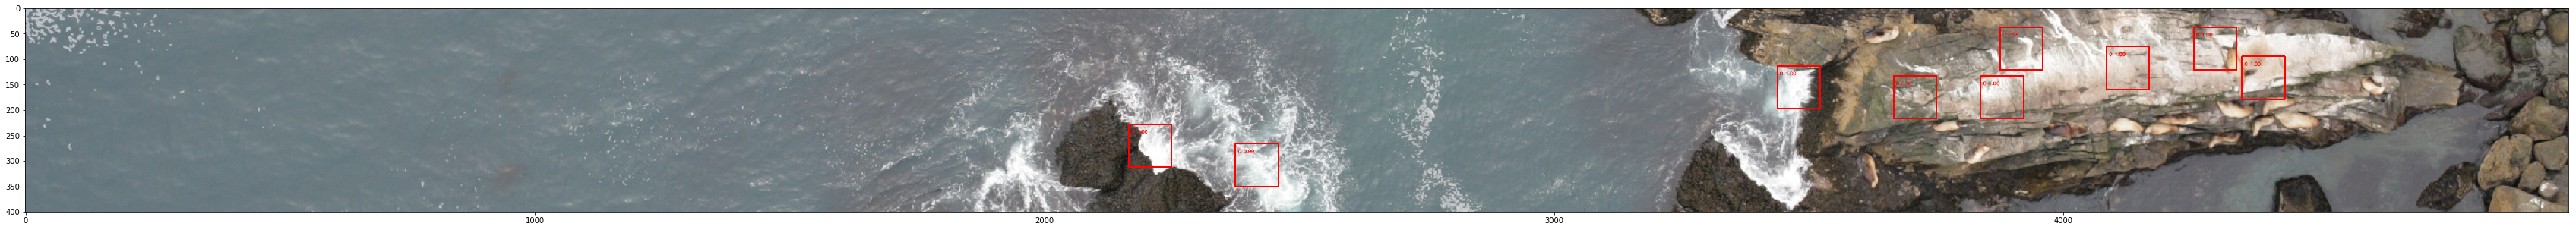

2017-06-08 14:24:00,946 INFO showing 9 images
2017-06-08 14:24:01,001 INFO > [started] generating image patches. rows=1; cols=10...


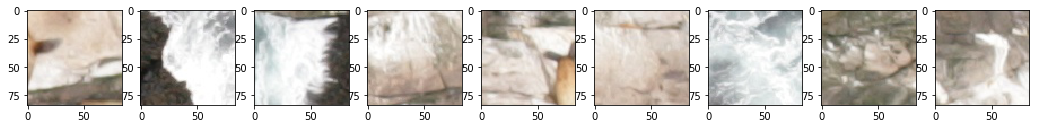

2017-06-08 14:24:01,782 INFO > [done]    generating image patches. rows=1; cols=10 (780.467 ms)


In [7]:
def detection_to_colortext(detection):
    score = detection[4]
    text = str(int(detection[5])) + ' ' + '{0:.2f}'.format(score)
    c = int(score*255)
    return (0,0,c), text

objectdetect.draw_detections(detections, img2, detection_to_colortext)
utils.show_image(img2, size=60, is_bgr=True)

patches = objectdetect.extract_patches(detections, img)
utils.show_images(patches[0:50], size=2, cols=10, is_bgr=True)

### Verify classification/count performance

2017-06-08 14:24:01,875 INFO sea lions found: 15
2017-06-08 14:24:01,876 INFO sea lions added to dataset: 15
2017-06-08 14:24:01,877 INFO non sea lions added to dataset: 0


  ground positives: 15
detected positives: 9
   false positives: 9
    true positives: 0
  overall accuracy: 0.00


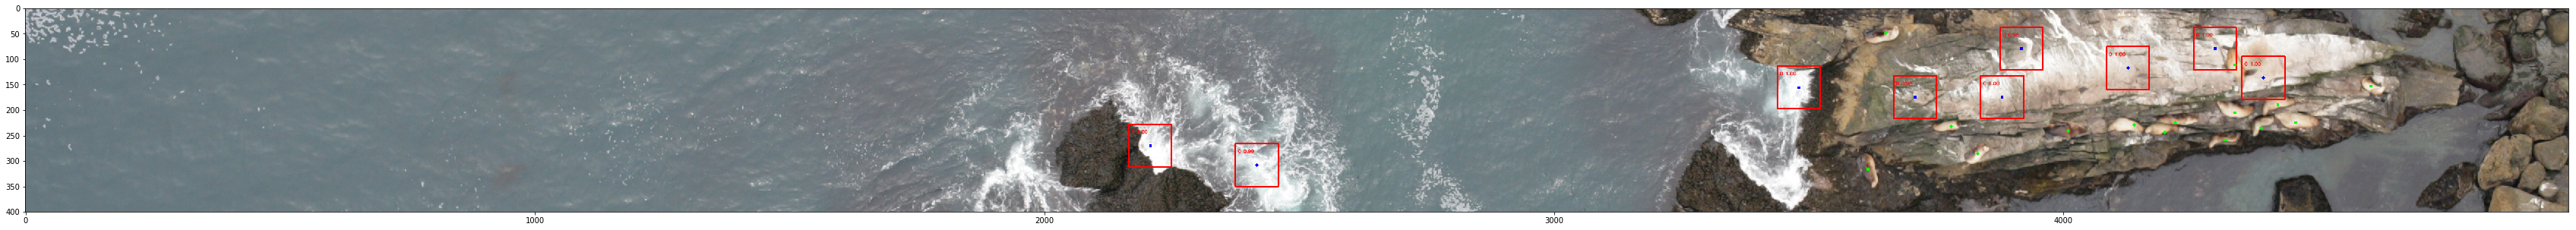

2017-06-08 14:24:03,773 INFO showing 9 images
2017-06-08 14:24:03,776 INFO > [started] generating image patches. rows=1; cols=10...


false positives (red is OK, blue are false positives)


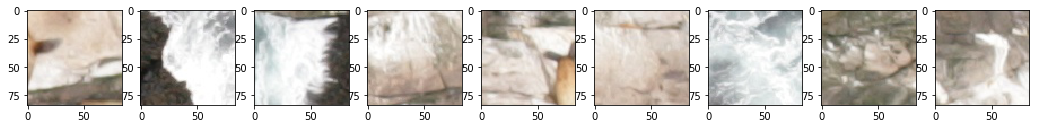

2017-06-08 14:24:04,492 INFO > [done]    generating image patches. rows=1; cols=10 (716.002 ms)


In [8]:
classes_count_total,classes_count_added,lion_positions,lion_classes = lions.export_lions(img, imgd, None, None, IMAGE_DIMS, debug=False, min_distance_others=0, export_non_lion=False)
#print(lion_positions)

for i,lp in enumerate(lion_positions):
    cv2.circle(img2, lp, 3, (0,255,0), -5)

false_positives = []
true_positives = []
#print(lion_positions)
for i,detection in enumerate(detections):
    patch_pos = (int(detection[1]+detection[3]/2),int(detection[0]+detection[2]/2))
    is_far = utils.is_far_from_others(patch_pos, lion_positions, 30)
#    print(str(i) + ' ' + str(patch_pos) + ' ' + str(is_far))
    
    color = (0,0,255)
    if(is_far):
        color = (255,0,0)
        false_positives.append(detection)
    else:
        true_positives.append(detection)
    cv2.circle(img2, patch_pos, 3, color, -5)

fp = objectdetect.extract_patches(false_positives, img)

print('  ground positives: ' + str(len(lion_positions)))
print('detected positives: ' + str(len(detections)))
print('   false positives: ' + str(len(false_positives)))
print('    true positives: ' + str(len(true_positives)))
print('  overall accuracy: ' + '{0:.2f}'.format(len(true_positives)/len(lion_positions)))

utils.show_image(img2, is_bgr=True, size=60)
print('false positives (red is OK, blue are false positives)')
utils.show_images(fp, size=2, cols=10, is_bgr=True)

## Export false positive samples

### Prepare output dataset

In [9]:
x_ds = None
y_ds = None

logger.info('creating dataset')
dataset_path = OUTPUT_DIR + utils.dataset_name('lion-patches-false-positives', IMAGE_DIMS)
h5file = h5py.File(dataset_path, 'w')
x_ds, y_ds = utils.create_xy_dataset(h5file, IMAGE_DIMS, LABEL_DIMS, x_dtype='u1')
logger.info('done')

2017-06-08 14:24:04,501 INFO creating dataset
2017-06-08 14:24:04,508 INFO done


### Find and export all false positives

In [10]:
#from MismatchedTrainImages.txt
MISMATCHED = [3, 7, 9, 21, 30, 34, 71, 81, 89, 97, 151, 184, 215, 234, 242, 268, 290, 311, 331, 344, 380, 384, 406, 421, 469, 475, 490, 499, 507, 530, 531, 605, 607, 614, 621, 638, 644, 687, 712, 721, 767, 779, 781, 794, 800, 811, 839, 840, 869, 882, 901, 903, 905, 909, 913, 927, 946]
logger.info('loading train.csv')
train = pd.read_csv(INPUT_DIR + "Train/train.csv")
FORCE_IMAGES = [42]

2017-06-08 14:24:04,532 INFO loading train.csv


2017-06-08 14:24:04,655 INFO process all photos from train file
2017-06-08 14:24:04,661 INFO > [started] processing photo ../../input/kaggle-sea-lion/Train/42.jpg...
2017-06-08 14:24:05,166 INFO sea lions found: 15
2017-06-08 14:24:05,167 INFO sea lions added to dataset: 15
2017-06-08 14:24:05,168 INFO non sea lions added to dataset: 0
2017-06-08 14:24:05,170 INFO pyramid layer=0 image=(400, 4992, 3) scale=1
2017-06-08 14:24:05,171 INFO > [started] sliding_window...


(400, 4992, 3)
399/400 [=========================>] 99% 97s remaining=0s sliding windoww

2017-06-08 14:25:42,331 INFO > [done]    sliding_window (97159.245 ms)
2017-06-08 14:25:42,332 INFO > [started] non_max_suppression. boxes=339461...
2017-06-08 14:25:43,155 INFO > [done]    non_max_suppression. boxes=339461 (823.206 ms)


  ground positives: 15
detected positives: 12
   false positives: 10
    true positives: 2
  overall accuracy: 0.13


2017-06-08 14:25:43,362 INFO showing 10 images
2017-06-08 14:25:43,365 INFO > [started] generating image patches. rows=3; cols=4...


false positives patches


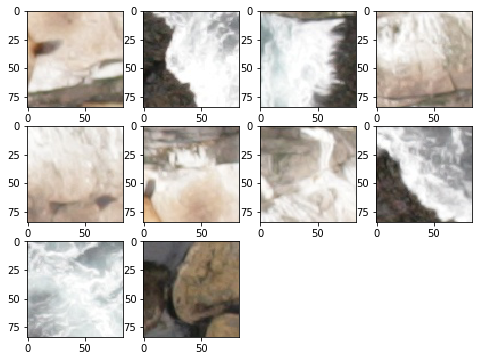

2017-06-08 14:25:44,258 INFO > [done]    generating image patches. rows=3; cols=4 (893.216 ms)
2017-06-08 14:25:44,263 INFO > [done]    processing photo ../../input/kaggle-sea-lion/Train/42.jpg (99602.478 ms)
2017-06-08 14:25:44,266 INFO GROUND TRUTH LIONS PER CLASS
2017-06-08 14:25:44,268 INFO [ 2.  4.  9.  0.  0.]
2017-06-08 14:25:44,270 INFO FALSE POSITIVES PER CLASS
2017-06-08 14:25:44,272 INFO [ 10.   0.   0.   0.   0.]
2017-06-08 14:25:44,273 INFO TRUE POSITIVES PER CLASS
2017-06-08 14:25:44,275 INFO [ 2.  0.  0.  0.  0.]
2017-06-08 14:25:44,276 INFO OVERALL ACCURACY:
2017-06-08 14:25:44,278 INFO 0.13


In [11]:
logger.info('process all photos from train file')

""" Returns (score, label) """
def eval_region(region_img):
    y_pred = model.predict(np.array([region_img]))
    ylp = utils.onehot_to_label(np.array(y_pred))
    return y_pred[0][ylp[0]], ylp[0]

total_lions = np.zeros(LABEL_DIMS[0]-1)
total_false_positives = np.zeros(LABEL_DIMS[0]-1)
total_true_positives = np.zeros(LABEL_DIMS[0]-1)
for row in train.itertuples():
    #load images
    train_id = row[1]
    
    if(FORCE_IMAGES!=None and train_id not in FORCE_IMAGES):
        continue
    
    image_raw_file = INPUT_DIR + 'Train/'+ str(train_id) +'.jpg'
    image_dotted_file = INPUT_DIR + 'TrainDotted/'+ str(train_id) +'.jpg'

    if(train_id in MISMATCHED):
        logger.warning('skipping mismatched train_id ' + str(train_id))
        continue
    
    if(not os.path.isfile(image_raw_file)):
        logger.warning('file not found. skipping. file=' + image_raw_file)
        continue

    t = Timer('processing photo ' + image_raw_file)
    image_raw = cv2.imread(image_raw_file)
    image_raw = image_raw[IMAGE_SLICE]
    image_dotted = cv2.imread(image_dotted_file)
    image_dotted = image_dotted[IMAGE_SLICE]

    #extract ground truth
    classes_count_total,classes_count_added,lion_positions,lion_classes = lions.export_lions(image_raw, image_dotted, None, None, IMAGE_DIMS, debug=DEBUG, min_distance_others=0, export_non_lion=False)
    for lc in lion_classes:
        total_lions[lc] += 1
    
    #search for lions
    region_generator = objectdetect.sliding_window_generator(image_raw, step=(19,19), window=IMAGE_DIMS, pyramid_max_layers=1, pyramid_scale=0.75)
    detections, imgs = objectdetect.evaluate_regions(region_generator, eval_region, filter_score_min=0.97, 
                                                     filter_labels=(0,1,2,3,4), apply_non_max_suppression=True, 
                                                     supression_overlap_threshold=0.08, threads=None)
    #compare ground truth to found lions
    false_positives = np.zeros(LABEL_DIMS[0]-1)
    false_positive_patches = []
    true_positives = np.zeros(LABEL_DIMS[0]-1)
    for i,detection in enumerate(detections):
        patch_pos = (int(detection[1]+detection[3]/2),int(detection[0]+detection[2]/2))
        is_far = utils.is_far_from_others(patch_pos, lion_positions, 30)
        if(is_far):
            false_positives[int(detection[5])] += 1
            false_positive_patches.append(detection)
        else:
            true_positives[int(detection[5])] += 1

    total_false_positives = np.add(total_false_positives, false_positives)
    total_true_positives = np.add(total_true_positives, true_positives)

    print('  ground positives: ' + str(len(lion_positions)))
    print('detected positives: ' + str(len(detections)))
    print('   false positives: ' + str(int(np.sum(false_positives))))
    print('    true positives: ' + str(int(np.sum(true_positives))))
    print('  overall accuracy: ' + '{0:.2f}'.format(np.sum(true_positives)/len(lion_positions)))

    false_positives_imgs = objectdetect.extract_patches(false_positive_patches, image_raw)
    
    for falseX in false_positives_imgs:
        utils.add_sample_to_dataset(x_ds, y_ds, falseX, utils.label_to_onehot([5], 6)[0])
    
    print('false positives patches')
    utils.show_images(false_positives_imgs[0:50], is_bgr=True, size=2)
    
    t.stop()
    
logger.info('GROUND TRUTH LIONS PER CLASS')
logger.info(str(total_lions))
logger.info('FALSE POSITIVES PER CLASS')
logger.info(str(total_false_positives))
logger.info('TRUE POSITIVES PER CLASS')
logger.info(str(total_true_positives))

logger.info('OVERALL ACCURACY:')
logger.info('{0:.2f}'.format(np.sum(total_true_positives)/np.sum(total_lions)))
#logger.info('OVERALL ACCURACY PER CLASS:')
#logger.info('{0:.2f}'.format(total_true_positives/total_lions))

h5file.close()